In [1]:
import numpy as np
import joblib
import os
import pandas as pd

# 使用网格搜索方法来进行参数选择
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from collections import Counter
# 使用StratifiedShuffleSplit类进行分层抽样
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from data_process.light_curve import ASASLightCurve

# 使用StratifiedShuffleSplit类进行分层抽样
from sklearn.model_selection import train_test_split

In [3]:

eclipsing_binary_list = np.load("../dataset/light_curve_instance/eclipsing_binary/lc_eclipsing_binary.npy",
                                allow_pickle=True)
len(eclipsing_binary_list)

KeyboardInterrupt: 

In [ ]:
print(eclipsing_binary_list[0].meta)

In [ ]:
from tqdm import tqdm

full_lc_pd = pd.DataFrame(columns=eclipsing_binary_list[0].meta.keys())
for lc in tqdm(eclipsing_binary_list):
    full_lc_pd = full_lc_pd.append(lc.meta, ignore_index=True)
full_lc_pd

In [ ]:
full_lc_pd.to_csv("../dataset/light_curve_dataframe/eclipsing_binary/lc_eclipsing_binary.csv", index=False)

In [2]:
full_lc_pd = pd.read_csv("../dataset/light_curve_dataframe/eclipsing_binary/lc_eclipsing_binary.csv")

In [3]:
full_lc_pd.columns.tolist()

['source_id',
 'raj2000',
 'dej2000',
 'l',
 'b',
 'mean_vmag',
 'amplitude',
 'period',
 'variable_type',
 'class_probability',
 'lksl_statistic',
 'rfr_score',
 'epoch_hjd',
 'gdr2_id',
 'phot_g_mean_mag',
 'e_phot_g_mean_mag',
 'phot_bp_mean_mag',
 'e_phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'e_phot_rp_mean_mag',
 'bp_rp',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'vt',
 'dist',
 'j_mag',
 'e_j_mag',
 'h_mag',
 'e_h_mag',
 'k_mag',
 'e_k_mag',
 'w1_mag',
 'e_w1_mag',
 'w2_mag',
 'e_w2_mag',
 'w3_mag',
 'e_w3_mag',
 'w4_mag',
 'e_w4_mag',
 'j_k',
 'w1_w2',
 'w3_w4',
 'apass_dr9_id',
 'apass_vmag',
 'e_apass_vmag',
 'apass_bmag',
 'e_apass_bmag',
 'apass_gpmag',
 'e_apass_gpmag',
 'apass_rpmag',
 'e_apass_rpmag',
 'apass_ipmag',
 'e_apass_ipmag',
 'b_v',
 'e_b_v',
 'vector_x',
 'vector_y',
 'vector_z',
 'periodic',
 'created_at',
 'updated_at',
 'nuvmag',
 'e_nuvmag',
 'pm',
 'ruwe',
 'main_type',
 'mean',
 'median',
 's

In [4]:
# full_lc_pd_ell = full_lc_pd[full_lc_pd["variable_type"]=="ELL"]
# full_lc_pd = full_lc_pd[full_lc_pd["variable_type"]!="ELL"][:10000]
# full_lc_pd = full_lc_pd.append(full_lc_pd_ell)

In [52]:
sub_class = full_lc_pd["variable_type"]
# features_drop_unlabel = full_lc_pd[useful_feature_cepheids1]
features_drop_unlabel = full_lc_pd.drop(
    labels=["source_id", "class_probability", "variable_type", "created_at", "main_type", "updated_at", "raj2000",
            "dej2000", "mean_vmag", "lksl_statistic", "rfr_score", "epoch_hjd", "e_b_v", "vector_x", "vector_y",
            "vector_z", "periodic", "l", "b"], axis=1)
features_drop_unlabel = features_drop_unlabel.dropna(axis=1)
features_drop_unlabel

,amplitude,period,mean,median,std,skewness,kurtosis,shapiro_w,IQR,p2p,...,b54,depth_ratio,slope_diff_ratio,similarity,phase_eta,slope_per10,slope_per90,slope_per20,slope_per80,phase_cusum
0,0.43,0.369614,14.247599,14.202,0.142713,0.500412,-1.145314,0.904199,0.26200,0.487,...,0.016009,0.000000,1.107516,0.987844,0.069590,-0.107168,0.105149,-0.044136,0.048258,0.272312
1,0.21,1.992654,12.382639,12.412,0.070507,-0.396765,-1.408323,0.877730,0.12950,0.232,...,0.725250,0.012931,1.211936,0.966092,0.539229,-1.484450,1.349271,-0.698874,0.537312,0.197429
2,0.21,1.992654,12.410763,12.412,0.059859,0.434794,-0.129593,0.966451,0.08200,0.263,...,-0.414279,0.003802,2.353940,0.975938,0.887772,-0.592608,0.904362,-0.251150,0.370921,0.216416
3,0.36,0.412779,13.185738,13.140,0.113869,0.724848,-0.915747,0.864701,0.19300,0.368,...,-0.068455,0.021739,1.109102,0.983095,0.046302,-0.298712,0.267680,-0.161734,0.096642,0.250773
4,0.36,0.412779,13.175300,13.140,0.116021,0.524846,-1.084964,0.902068,0.20800,0.396,...,-0.010638,0.002525,1.348041,0.982628,0.089193,-0.203587,0.226081,-0.098112,0.109488,0.230508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127334,0.13,0.468586,13.668373,13.663,0.038960,0.217261,-0.895774,0.970155,0.06075,0.163,...,0.659398,0.042945,1.085785,0.956323,0.715128,-0.353347,0.371974,-0.169320,0.148949,0.211349
127335,0.50,5.021012,13.436705,13.413,0.084740,4.134982,19.600252,0.471157,0.02050,0.597,...,1.192759,0.556114,6.169001,0.950807,0.844292,-11.960270,10.664640,-4.298160,3.294531,0.161760
127336,0.50,5.021012,13.439635,13.413,0.099210,3.254838,10.122744,0.490252,0.02125,0.551,...,0.591638,0.284936,1.264316,0.939473,0.293483,-4.076498,3.908200,-1.559490,1.362397,0.165524
127337,0.17,0.402175,14.162061,14.165,0.052464,-0.011596,-1.192687,0.957627,0.08950,0.193,...,-2.461598,0.010363,1.115968,0.971849,0.374355,-0.173481,0.144664,-0.080845,0.057095,0.234512


In [53]:
label_encoder = LabelEncoder()
sub_class = label_encoder.fit_transform(sub_class)
sub_class = sub_class.astype(np.int32)

In [54]:
from sklearn.decomposition import PCA
fnum = 30
pca = PCA(n_components=fnum,random_state=0)

In [55]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(features_drop_unlabel, sub_class, test_size=0.2, shuffle=True,
                                                    random_state=0)
pca.fit(X_train,y_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# X_train, y_train = SMOTE().fit_resample(X_train, y_train)
# X_train, y_train = ADASYN().fit_resample(X_train, y_train)
# X_train, y_train = SVMSMOTE().fit_resample(X_train, y_train)
# X_train, y_train = SVMSMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

[(0, 31472), (1, 15855), (2, 70), (3, 54474)]


In [56]:
import lightgbm as lgb

param_grid = [
    {'learning_rate': [0.01, 0.05,0.1,0.2], 'n_estimators': range(20, 201, 20)},
]
clf = lgb.LGBMClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=10)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START learning_rate=0.01, n_estimators=20........................
[CV 1/5; 1/40] END learning_rate=0.01, n_estimators=20;, score=(train=0.769, test=0.772) total time=   0.2s
[CV 2/5; 1/40] START learning_rate=0.01, n_estimators=20........................
[CV 2/5; 1/40] END learning_rate=0.01, n_estimators=20;, score=(train=0.769, test=0.769) total time=   0.2s
[CV 3/5; 1/40] START learning_rate=0.01, n_estimators=20........................
[CV 3/5; 1/40] END learning_rate=0.01, n_estimators=20;, score=(train=0.771, test=0.766) total time=   0.2s
[CV 4/5; 1/40] START learning_rate=0.01, n_estimators=20........................
[CV 4/5; 1/40] END learning_rate=0.01, n_estimators=20;, score=(train=0.772, test=0.774) total time=   0.2s
[CV 5/5; 1/40] START learning_rate=0.01, n_estimators=20........................
[CV 5/5; 1/40] END learning_rate=0.01, n_estimators=20;, score=(train=0.772, test=0.768) total time= 

In [57]:
grid_search.score(X_test, y_test)

0.9287340976912204

In [58]:

cvres = grid_search.cv_results_
if not os.path.exists("../output/eclipsing_binary"):
    os.makedirs("../output/eclipsing_binary")
with open(f"../output/eclipsing_binary/lgbm_eclipsing_binary_pca{fnum}.txt", "w") as f:
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        f.write(str(mean_score) + str(params) + "\n")

In [59]:
# 计算每种特征对分类结果的影响
feature_name = features_drop_unlabel.columns
feature_importances = grid_search.best_estimator_.feature_importances_
if not os.path.exists("../output/eclipsing_binary"):
    os.makedirs("../output/eclipsing_binary")
with open(f"../output/eclipsing_binary/lgbm_eclipsing_binary_pca{fnum}_feature_importance.txt", "w") as f:
    for i in range(len(feature_importances)):
        f.write(str(feature_importances[i]) + " " + str(feature_name[i]) + "\n")

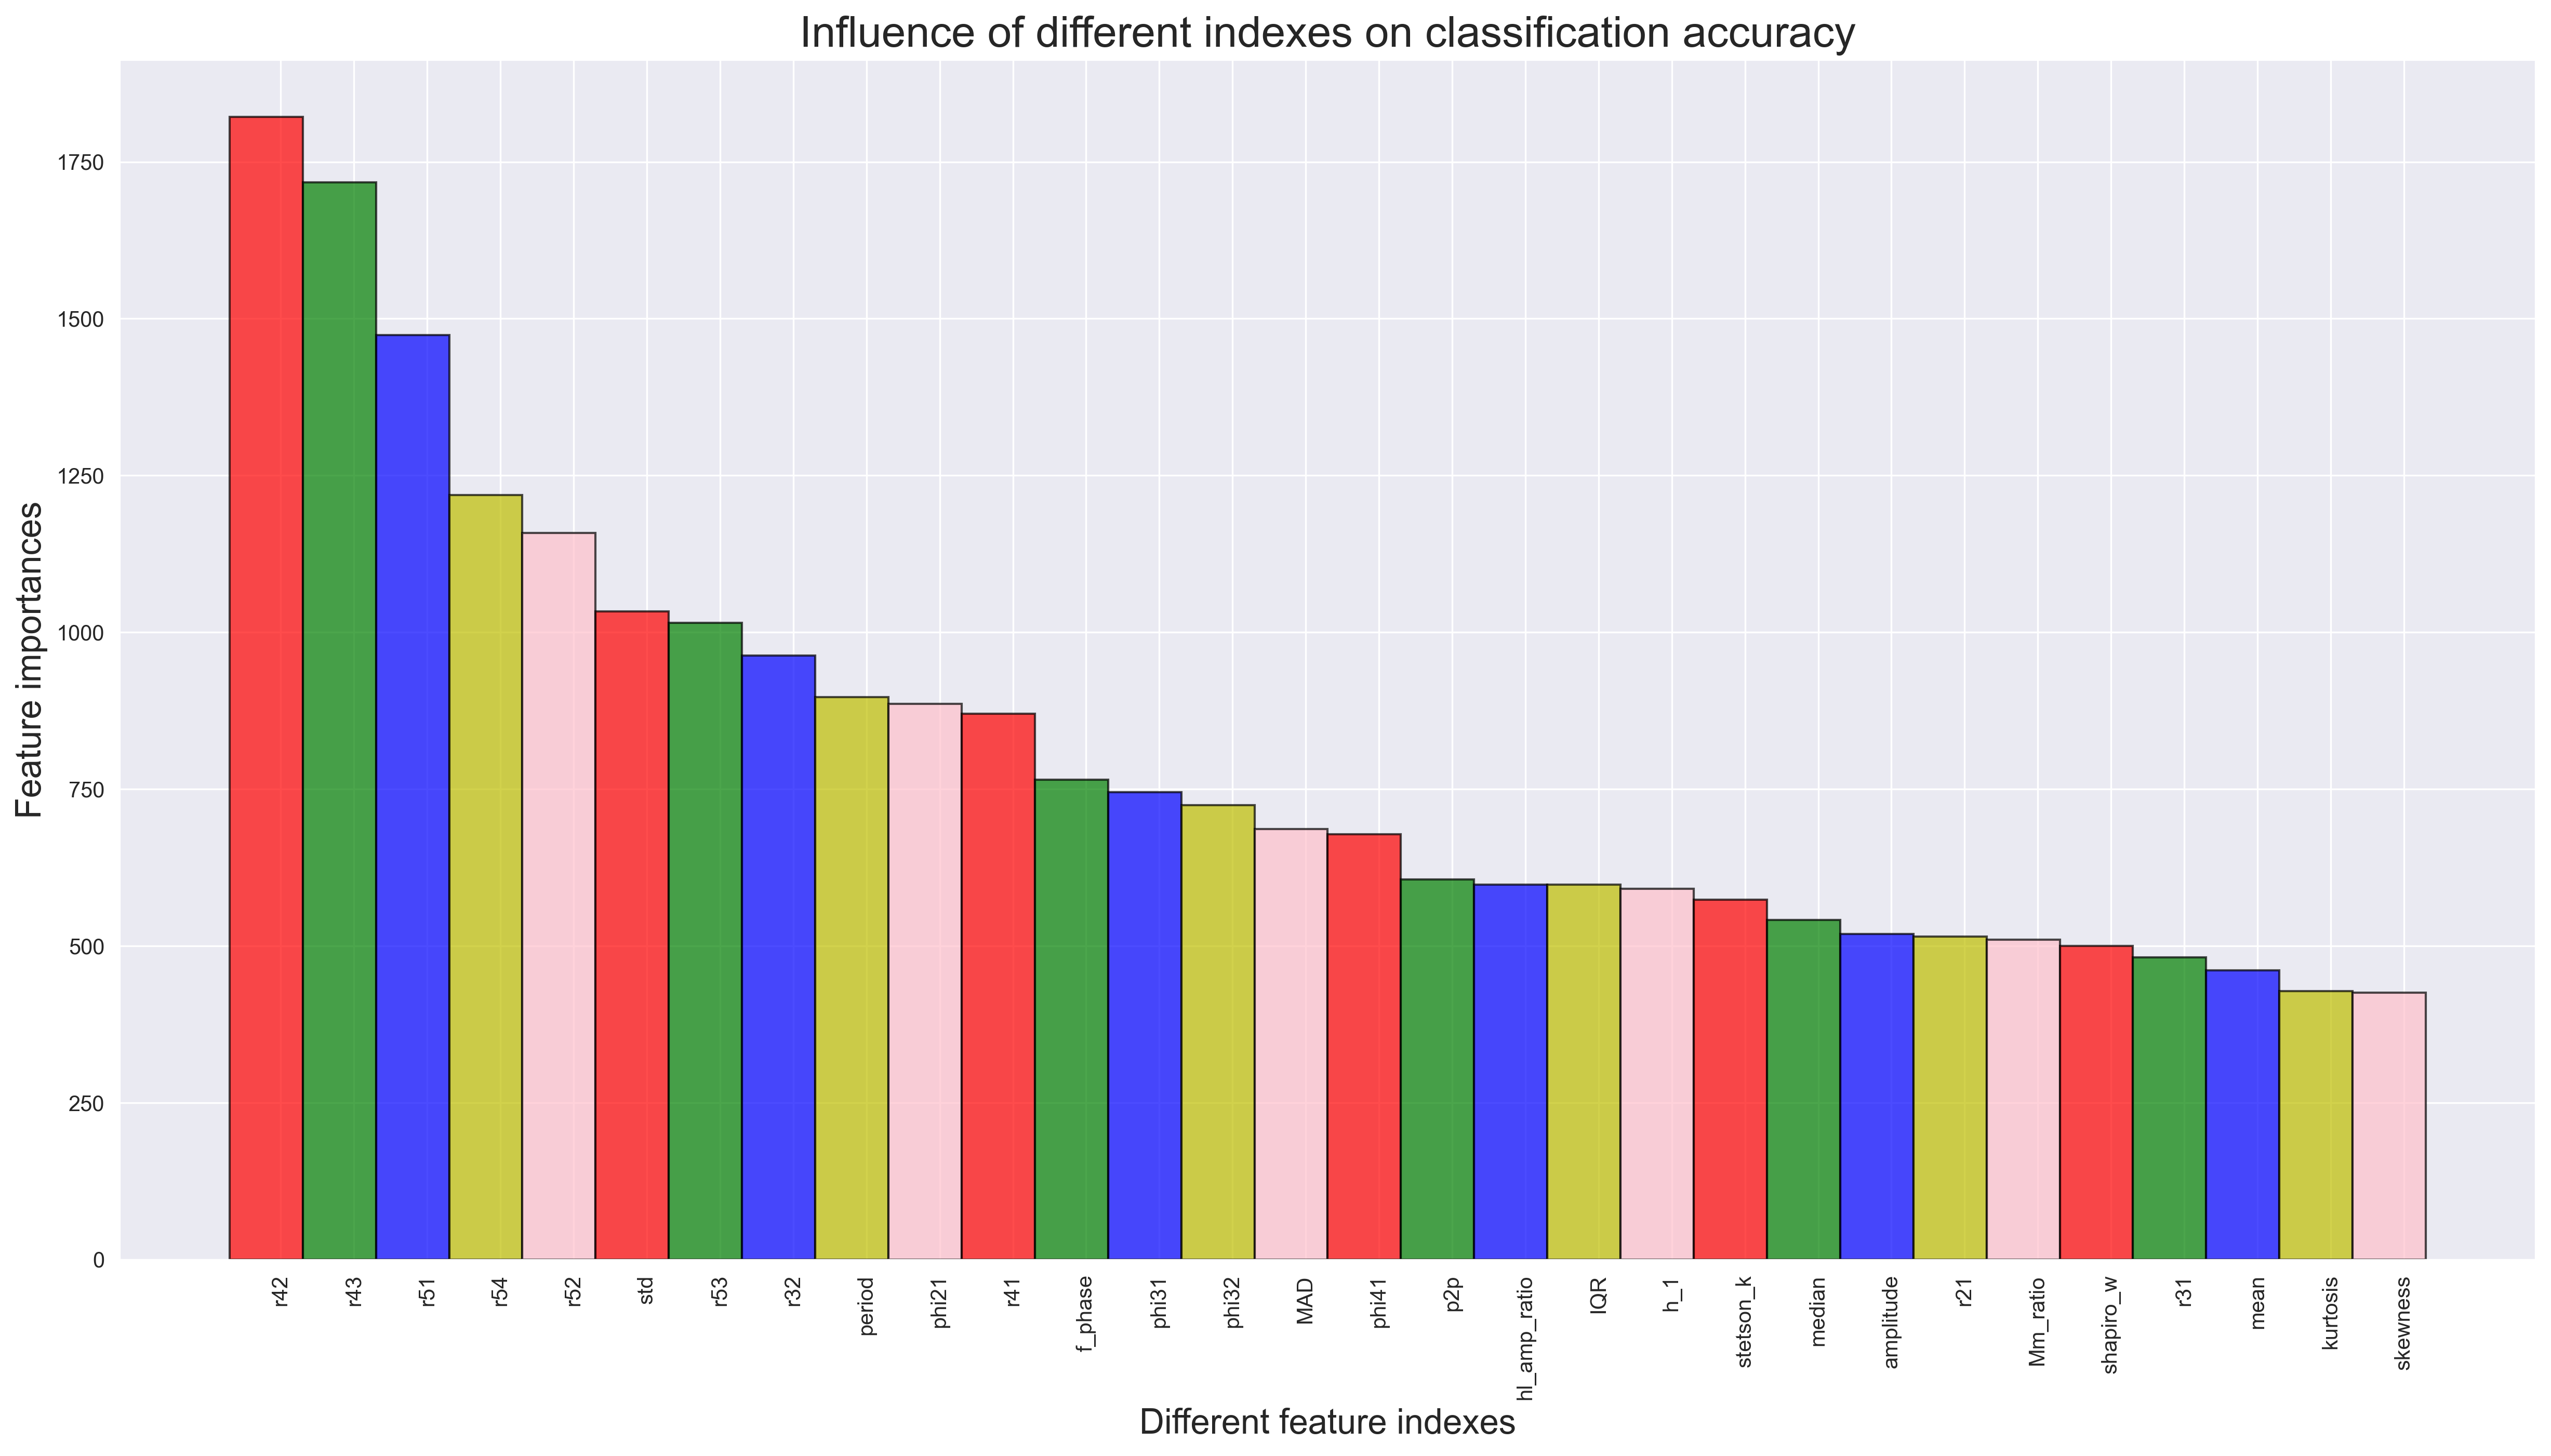

FileNotFoundError: [Errno 2] No such file or directory: './output/feature_important/random_forest_cepheids_importance_0.9292438617484935.png'

<Figure size 640x480 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt

importances = sorted(zip(feature_importances, feature_name), reverse=True)
feature_im = []
feature_n = []
for i in importances:
    feature_im.append(i[0])
    feature_n.append(i[1])
plt.figure(figsize=(20, 10), dpi=300)
indexes = np.arange(len(feature_im))
plt.title("Influence of different indexes on classification accuracy", fontsize=20)
plt.xlabel("Different feature indexes", fontsize=16)
plt.ylabel("Feature importances", fontsize=16)
plt.bar(2 * indexes, feature_im, 2, edgecolor="black", alpha=0.7, color=['r', 'g', 'b', 'y', 'pink'])
plt.xticks(2 * indexes + 2 * 0.2, feature_n, rotation=90)
plt.show()
plt.savefig(f"./output/feature_important/random_forest_cepheids_importance_{grid_search.best_score_}.png")

([<matplotlib.axis.YTick at 0x1ef8306e6e0>,
 [Text(0, 0, 'EA'), Text(0, 1, 'EB'), Text(0, 2, 'ELL'), Text(0, 3, 'EW')])

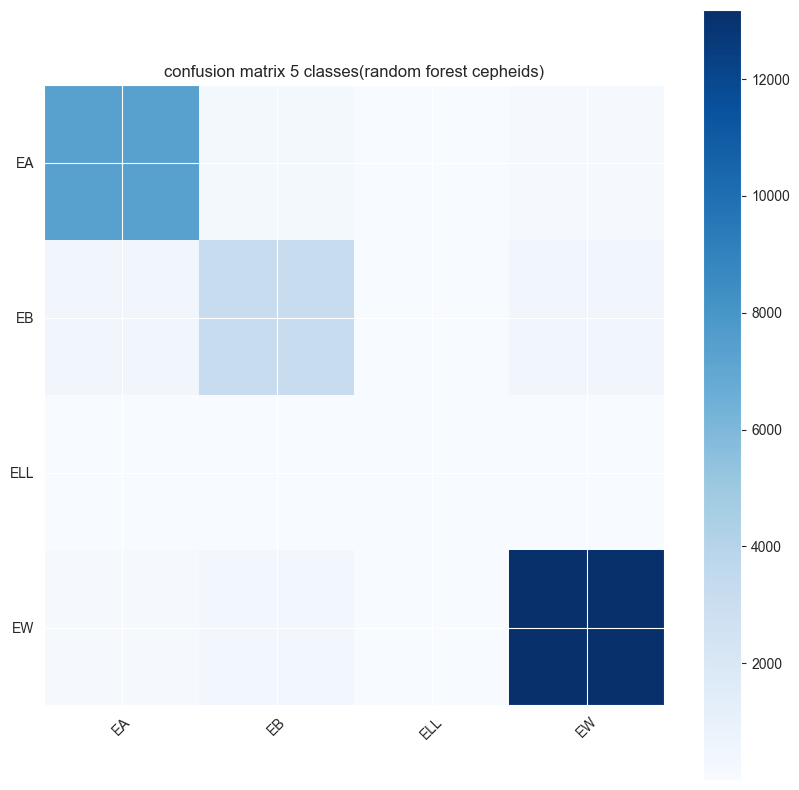

In [61]:
# from my_util.utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

classes = np.unique(np.concatenate([np.array(y_test), np.array(y_pred)]))
classes = label_encoder.inverse_transform(classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion matrix 5 classes(random forest cepheids)')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

In [62]:
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

# print(recall_score(y_test, y_pred, average='macro'))
# print(f1_score(y_test, y_pred, average='macro'))
# print(precision_score(y_test, y_pred, average='macro'))
# print(recall_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=["EA", "EB", "ELL", "EW"], digits=4))

              precision    recall  f1-score   support

          EA     0.9282    0.9413    0.9347      7809
          EB     0.8348    0.7803    0.8066      3996
         ELL     0.1667    0.1765    0.1714        17
          EW     0.9555    0.9659    0.9607     13646

    accuracy                         0.9287     25468
   macro avg     0.7213    0.7160    0.7184     25468
weighted avg     0.9276    0.9287    0.9280     25468



In [218]:
joblib.dump(label_encoder, f"./output/label_encoder/cepheids_label_{grid_search.best_score_}.pkl")

FileNotFoundError: [Errno 2] No such file or directory: './output/label_encoder/cepheids_label_0.9398847948275229.pkl'

In [37]:
root = os.getcwd().split("train")[0]
features_root = os.path.join(root, "datasets", "new_astronomy_lc_features_v1")
full_lc = np.load(os.path.join(features_root, "cepheids_var.npy"), allow_pickle=True)
full_lc_list = full_lc.tolist()
full_lc_pd = pd.DataFrame(full_lc_list)
full_lc_pd = full_lc_pd[full_lc_pd["class_probability"] >= 0.95]

sub_class = full_lc_pd["type"]
features_drop_unlabel = full_lc_pd[useful_feature_cepheids_new]
features_drop_unlabel = features_drop_unlabel.drop(labels=["class_probability", "type"], axis=1)
features_drop_unlabel = features_drop_unlabel.dropna(axis=1)

label_encoder = LabelEncoder()
sub_class = label_encoder.fit_transform(sub_class)
sub_class = sub_class.astype(np.int32)

np.random.seed(42)
# 0:92204
# 1:9005 2:905913  3:9139  4:90322 5:93817  6:87903
X_train, X_test, y_train, y_test = train_test_split(features_drop_unlabel, sub_class, test_size=0.2,
                                                    shuffle=True, random_state=5)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

param_grid = [
    {'n_estimators': range(10, 31, 5), 'max_features': range(10, 51, 5)},
    {'bootstrap': [False], 'n_estimators': range(10, 31, 5), 'max_features': range(10, 51, 5)}
]
clf = RandomForestClassifier(n_jobs=-1)
grid_search_new = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=10)

grid_search_new.fit(X_train, y_train)
print(grid_search_new.best_params_)
print(grid_search_new.best_estimator_)
print(grid_search_new.best_score_)
grid_search_new.score(X_test, y_test)

[(0, 1005), (1, 1005), (2, 1005), (3, 1005), (4, 1005)]
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5; 1/90] START max_features=10, n_estimators=10...........................
[CV 1/5; 1/90] END max_features=10, n_estimators=10;, score=(train=0.999, test=0.959) total time=   0.0s
[CV 2/5; 1/90] START max_features=10, n_estimators=10...........................
[CV 2/5; 1/90] END max_features=10, n_estimators=10;, score=(train=0.998, test=0.958) total time=   0.0s
[CV 3/5; 1/90] START max_features=10, n_estimators=10...........................
[CV 3/5; 1/90] END max_features=10, n_estimators=10;, score=(train=0.999, test=0.977) total time=   0.0s
[CV 4/5; 1/90] START max_features=10, n_estimators=10...........................
[CV 4/5; 1/90] END max_features=10, n_estimators=10;, score=(train=0.999, test=0.972) total time=   0.0s
[CV 5/5; 1/90] START max_features=10, n_estimators=10...........................
[CV 5/5; 1/90] END max_features=10, n_estimators=10;, sco

0.9059139784946236

In [31]:
save_path = os.path.join(root, "model_name/") + f"random_forest_cepheids_{grid_search_new.best_score_}.model"
joblib.dump(grid_search_new, save_path)

['F:\\WorkSpace\\Pycharm\\天文项目\\ASAS-Classification_v5\\model_name/random_forest_cepheids_0.9767164179104476.model']

In [32]:
cvres = grid_search_new.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9669651741293531 {'max_features': 10, 'n_estimators': 10}
0.9741293532338308 {'max_features': 10, 'n_estimators': 15}
0.9751243781094528 {'max_features': 10, 'n_estimators': 20}
0.976318407960199 {'max_features': 10, 'n_estimators': 25}
0.9767164179104476 {'max_features': 10, 'n_estimators': 30}
0.9649751243781095 {'max_features': 15, 'n_estimators': 10}
0.9701492537313433 {'max_features': 15, 'n_estimators': 15}
0.973134328358209 {'max_features': 15, 'n_estimators': 20}
0.9739303482587065 {'max_features': 15, 'n_estimators': 25}
0.9735323383084576 {'max_features': 15, 'n_estimators': 30}
0.9623880597014924 {'max_features': 20, 'n_estimators': 10}
0.9699502487562188 {'max_features': 20, 'n_estimators': 15}
0.9711442786069652 {'max_features': 20, 'n_estimators': 20}
0.9717412935323383 {'max_features': 20, 'n_estimators': 25}
0.9741293532338308 {'max_features': 20, 'n_estimators': 30}
0.9677611940298508 {'max_features': 25, 'n_estimators': 10}
0.9669651741293533 {'max_features': 25, 'n

In [33]:
# 计算每种特征对分类结果的影响
feature_name = features_drop_unlabel.columns
feature_importances = grid_search_new.best_estimator_.feature_importances_
sorted(zip(feature_importances, feature_name), reverse=True)

[(0.12601571120284158, 'ambient_light'),
 (0.11910734953437324, 'r21'),
 (0.0818942847613223, 'period'),
 (0.04726507061073445, 'r31'),
 (0.04632582313057719, 'h_1'),
 (0.040894937760115255, 'slope_per10'),
 (0.030819654009651764, 'eta'),
 (0.028723217311932333, 'r41'),
 (0.026572414912126238, 'phase_cusum'),
 (0.026068662707511306, 'slope_per90'),
 (0.02526140209730426, 'skewness'),
 (0.023784658806753692, 'IQR'),
 (0.022929998846490694, 'MAD'),
 (0.021875709726225014, 'theta_w'),
 (0.021650437674981104, 'variation'),
 (0.02000014955784285, 'amplitude'),
 (0.019235961697496792, 'Mm'),
 (0.019122719728551528, 'l1'),
 (0.018219907422578098, 'hl_amp_ratio'),
 (0.017950306702426835, 'std'),
 (0.014972995347532337, 'r53'),
 (0.01261653044336245, 'r51'),
 (0.009567929932679948, 'RoMS'),
 (0.009012387367914987, 'a2'),
 (0.008442200729528738, 'phase_eta'),
 (0.008305350312270214, 'median'),
 (0.007859240603221334, 'a42'),
 (0.007832562716921497, 'theta_NXS'),
 (0.0076874630055793905, 'mean_vm

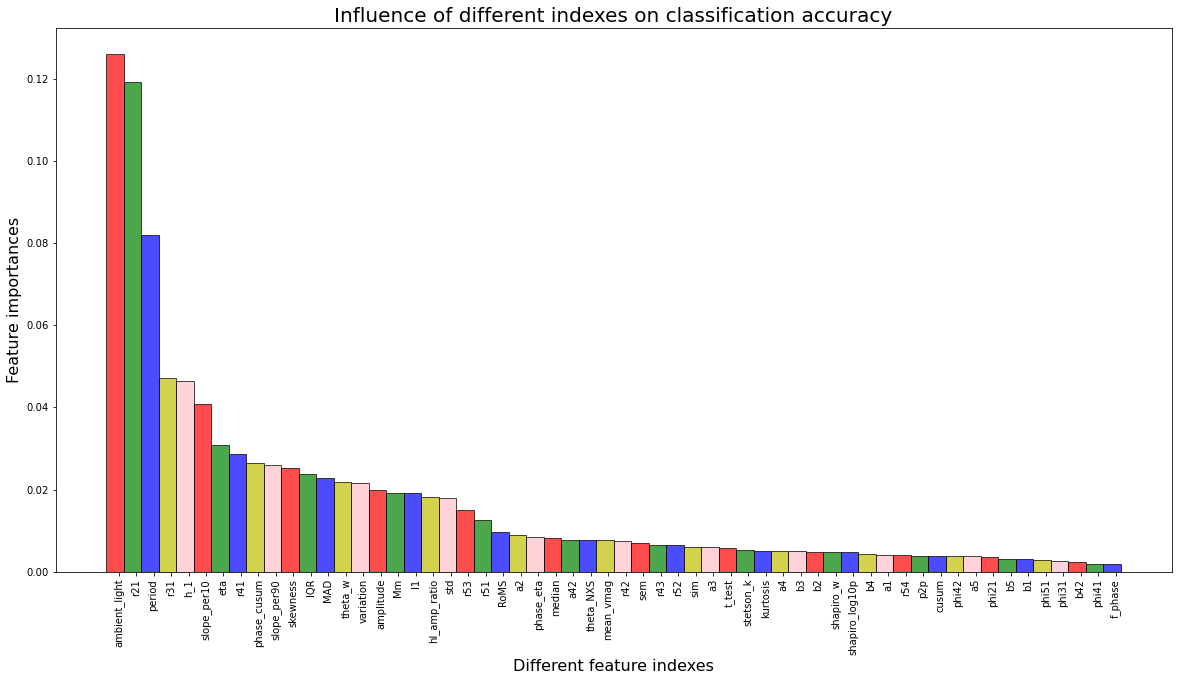

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt

importances = sorted(zip(feature_importances, feature_name), reverse=True)
feature_im = []
feature_n = []
for i in importances:
    feature_im.append(i[0])
    feature_n.append(i[1])
plt.figure(figsize=(20, 10))
indexes = np.arange(len(feature_im))
plt.title("Influence of different indexes on classification accuracy", fontsize=20)
plt.xlabel("Different feature indexes", fontsize=16)
plt.ylabel("Feature importances", fontsize=16)
plt.bar(2 * indexes, feature_im, 2, edgecolor="black", alpha=0.7, color=['r', 'g', 'b', 'y', 'pink'])
plt.xticks(2 * indexes + 2 * 0.2, feature_n, rotation=90)
plt.show()
plt.savefig(f"./output/feature_important/random_forest_cepheids_importance_{grid_search_new.best_score_}.png")

['CWA' 'CWB' 'DCEP' 'DCEPS' 'RVA']


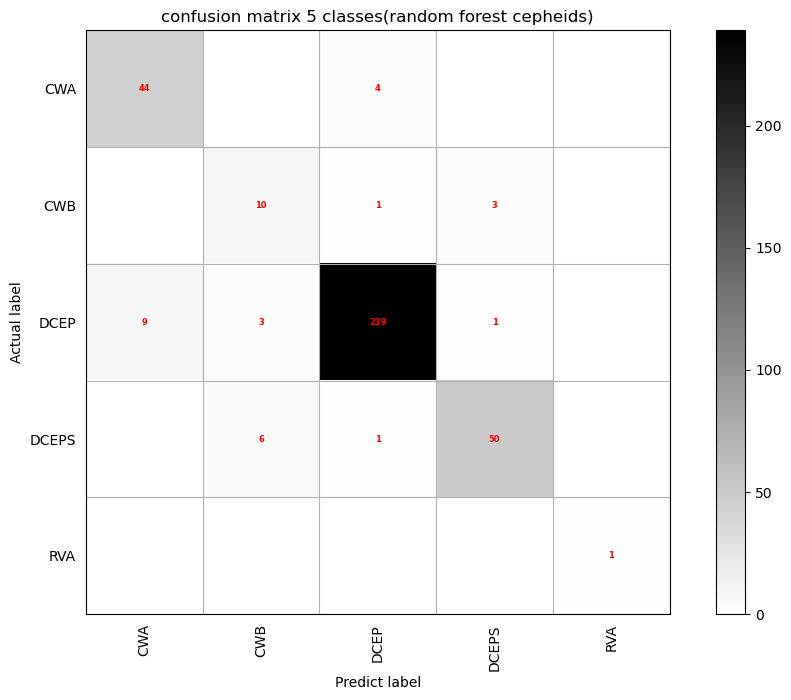

In [35]:
from my_util.utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = grid_search_new.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

classes = np.unique(np.concatenate([np.array(y_test), np.array(y_pred)]))
classes = label_encoder.inverse_transform(classes)
print(classes)

save_path = os.path.join(root, "output",
                         "confusion_matrix/") + f"confusion_matrix_random_forest_cepheids_{grid_search_new.best_score_}.png"
plot_confusion_matrix(cm, save_path, classes=classes, title='confusion matrix 5 classes(random forest cepheids)')

In [36]:
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

print(recall_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, target_names=classes))

0.9247311827956989
0.9274843526814953
0.9323221152224581
0.9247311827956989
              precision    recall  f1-score   support

         CWA       0.83      0.92      0.87        48
         CWB       0.53      0.71      0.61        14
        DCEP       0.98      0.95      0.96       252
       DCEPS       0.93      0.88      0.90        57
         RVA       1.00      1.00      1.00         1

    accuracy                           0.92       372
   macro avg       0.85      0.89      0.87       372
weighted avg       0.93      0.92      0.93       372

